<font size="5"><b>Lecture 09: Machine Learning 3 (exercises)</b></font>

# EX: Semantic classification of satellite image

<div class="alert alert-info">
<b>This exercise has been developed by <u>Andreas Ley</u> and <u>Ronny Hänsch</u> (TU-Berlin) in the framework of the GEO.X 2017 Autumn school.<br>
<br>
The exercise is designed to implement the classification of a satellite image (Sentinel-2) into semantic labels defining land use: forest, fields, urban, water.<br>
<br>
The exercise is split into 2 parts: the first part implements a PCA analysis on the image crops in order to reduce dimensionality, and the second part uses the outputs of the PCA and implement a SVM to classify the pixels into different land use classes.
</b>
<br>
<br>
<img src="images/application_input.png" width="400"><br>
</div>

<div class="alert alert-info">
<b><u>Description of the dataset</u></b>:<br>
<br>
<b>Part 1</b>: In the first part of the exercise, you will use the file <u>s2_training_data.npz</u>. It contains image crops of a Sentinel-2 multispectral image, and some semantic labels of land use.<br>
    <br>
    The file can be loaded using <a href="https://numpy.org/doc/stable/reference/generated/numpy.load.html?highlight=load#numpy.load" target="_blank">numpy.load()</a>, and contains 2 parts:<br>
    <ul>
        <li><u>data</u>: contains 20,000 patches (crops), each of 15x15 pixels and 4 channels (R + G + B + shortwave-infrared). The data is organized as one numpy array of shape (20000, 4, 15, 15), where the first dimension are the instances, the next dimension are the channels, and the latter two are width and height.<br> The first 5000 crops contain forest in the central pixel, the next 5000 contain fields/lower vegetation, the next 5000 are urban areas, and the last 5000 are water.</li>
        <li><u>labels</u>: contains semantic labels of land use (forest, fields, urban, water), which will be later used for training the classifier.</li>
    </ul>   
</div>

<div class="alert alert-info">
<b>Part 2</b>: In the second part of the exercise, in addition to the training data you will be using two other files:<br>
    <ul>
        <li><u>s2_testing_data.npz</u>: the file is structured like the training file "s2_training_data.npz", and will be used to evaluate our SVM classifier.</li>
        <br>
        <li><u>s2_application_data.npz</u>: the file only contains a "data" field, which stores a single Sentinel-2 image of 512x512 pixels, with 4 channels (R+G+B+SWIR). This image will be used to apply the trained SVM classifier in order to classify the pixels into the different land use classes (forest, fields, urban, water).</li>
    </ul>   
</div>

## PART 1 (PCA)

### load data

<div class="alert alert-success">
    Load the data using numpy.load(). Store the "data" in a variable named "train_X", anf the "labels" in a variable named "train_Y". Explore the shape of these arrays.
</div>

### inspect image crops

<div class="alert alert-success">
    Use the function below to look at the (RGB-part) of individual crops.<br>Take a look at the first crop of each class (remember: crops 1-5k contain forest, crops 5-10k contain fields, crops 10-15k are urban areas, and crops 15-20k are water).
</div>

In [4]:
def show_raw_image(img):
    img2 = np.log(img[[2,1,0],:,:])

    img2[0,:,:] = img2[0,:,:].copy() * 1.05303 + -6.32792
    img2[1,:,:] = img2[1,:,:].copy() * 1.74001 + -10.8407
    img2[2,:,:] = img2[2,:,:].copy() * 1.20697 + -6.73016

    img2 = np.clip(img2 / 6 + 0.5, 0.0, 1.0)

    plt.imshow(np.transpose(img2, (1, 2, 0)))
    plt.show()

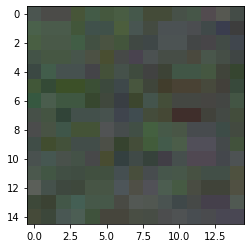

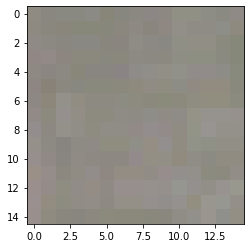

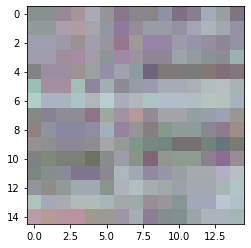

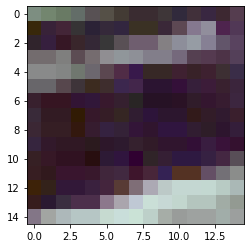

In [5]:
for i in range(0,4):
    show_raw_image(train_X[5000*i])

### compress image crops

<div class="alert alert-success">
    The data train_X contains the raw values which span a large range. To compress them into a more “gaussian” shape, compute the logarithm of them.
</div>

### build function to compute principal components of image crops
The following tasks will implement a function "compute_mean_PCs(X)" which takes image crops as inputs, and returns the mean image, Eigen images (principal components reshaped into images), and Eigen values.

#### compute mean crop, and mean-free crops

<div class="alert alert-success">
    Compute the mean image crop, and name the resulting array "mean".<br>
    Subtract this "mean" from all crops, and name the resulting array "mean_free".<br>
    <br>
    Hint: The mean image should be an array of shape (4, 15, 15), and the mean free crops should be an array of shape (20000, 4, 15, 15)).
</div>

#### vectorize the mean-free crops

<div class="alert alert-success">
    Flatten the crops into vectors so that you get a numpy array of shape (20000, 4 * 15 * 15).<br>
    <br>
    Hint: use "np.reshape".
</div>

#### compute the covariance matrix

<div class="alert alert-success">
    Compute the covariance matrix. This should be a matrix of size 900x900 (900 = 4 * 15 * 15).<br>
    <br>
    Start by defining a matrix of zeros with shape (900,900). Loop over all 20000 crops, and for each crop compute the outer product <a href="https://numpy.org/doc/stable/reference/generated/numpy.outer.html?highlight=outer#numpy.outer" target="_blank">np.outer(u, v)</a> of the mean-free vector with itself (i.e., u = v = vectorized crop). Accumulate (sum) the outer products together and finally divide by the total number of used crops. (To speed up development, consider using only every 10th crop).<br>
    <br>
    NB: the <a href="https://en.wikipedia.org/wiki/Outer_product" target="_blank">outer product</a> $u \otimes v$ is equivalent to a matrix multiplication $u \cdot v^T$
</div>

#### compute Eigen values & Eigen vectors of the covariance matrix

<div class="alert alert-success">
    Compute the Eigen values "eig_val" and Eigen vectors "eig_vec" of the covariance matrix using <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html?highlight=eig#numpy.linalg.eig" target="_blank">np.linalg.eig()</a>.<br>
    <br>
    Sort them by importance (decreasing Eigen values) using the following code:<br>
</div>

#### reshape Eigen vectors into Eigen images

<div class="alert alert-success">
    Reshape the 900 eigen vectors back into the images, i.e. with shape (900, 4, 15, 15), and name this variable "principal_components".<br>
    <br>
    Note that the matrix eig_vec contains the Eigen vectors in its rows (not columns as you might expect), so you'll need to transpose the matrix before reshaping it.
</div>

#### merge into function "compute_mean_PCs"

<div class="alert alert-success">
    Merge steps 1.4.1 to 1.4.4 into a single function "compute_mean_PCs".<br>
    <br>
    The function will take the image crops as inputs (i.e., variable "train_X"), and will return the mean image (i.e., variable "mean"), the Eigen images (principal components reshaped into images, i.e., variable "principal_components"), and Eigen values (i.e., variable "eig_val").
</div>

### run "compute_mean_PCs" and plot Eigen values

<div class="alert alert-success">
    Run "compute_mean_PCs" on the satellite data, and plot the returned Eigen values.<br>
    <br>
    Look at the first 64 principal components (or the RGB part thereof) using the following function:
</div>

In [22]:
def show_first_principal_components(pcs):

    f, axarr = plt.subplots(8,8)
    for i in range(0,8):
        for j in range(0,8):
            img2 = pcs[i*8+j, [2,1,0], :, :]
            img2 = np.clip(img2 * 10 + 0.5, 0.0, 1.0)
            axarr[i,j].imshow(np.transpose(img2, (1, 2, 0)))

    plt.show()

### compute features

<div class="alert alert-success">
    Write a function "compute_features(X, mean, principal_components, count)" that takes crops "X", subtracts the mean, and projects them onto the first "count" principal components.<br>
    <br>
    The returned array should have a shape (X.shape[0], count), containing the coefficients (which we will use as features in next week's exercise).<br>
    <br>
    Hint: the projection is done using the dot product.
</div>

### reconstruct image

<div class="alert alert-success">
    Write a function "reconstruct_image(feature, mean, principal_components)" that restores a crop given a feature/coefficient vector.<br>
    <br>
    Use the following code to compare, side by side, original image crops and reconstructions:
</div>

```python
# Code to compare, side by side, original image crops and reconstructions: 
for i in range(0,4):    
    img = np.concatenate((train_X[5000*i+0,:,:,:], reconstruct_image(train_features[5000*i+0,:], mean, principal_components)), 2);
    img = np.concatenate((img,np.concatenate((train_X[5000*i+1,:,:,:], reconstruct_image(train_features[5000*i+1,:], mean, principal_components)), 2)), 1);
    img = np.concatenate((img,np.concatenate((train_X[5000*i+2,:,:,:], reconstruct_image(train_features[5000*i+2,:], mean, principal_components)), 2)), 1);
    img = np.concatenate((img,np.concatenate((train_X[5000*i+3,:,:,:], reconstruct_image(train_features[5000*i+3,:], mean, principal_components)), 2)), 1);
    img = np.concatenate((img,np.concatenate((train_X[5000*i+4,:,:,:], reconstruct_image(train_features[5000*i+4,:], mean, principal_components)), 2)), 1);
    show_raw_image(np.exp(img))
```

## PART 2 (SVM classification)

### (optional) define functions developed in part 1

<div class="alert alert-success">
    The datasets contain 5k crops per class. Each crop is 15x15 pixels in size with 4 channels per pixel. The label of the central pixel is given in a separate array. Since the input dimensionality of each crop is quite high (4x15x15 = 900), we want to compress it using PCA.<br>
    The following function have been developped in the 1st part of the exercice.
</div>

### run PCA on training_data

<div class="alert alert-success">
    Use the functions implemented for the PCA exercise to compute the mean and principal components on the training data (s2_training_data.npz).<br>
    Compute a 16-dimensional feature vector for each training sample by using the "compute_features" function.
</div>

### train a SVM on PCA features

<div class="alert alert-success">
    Train a support vector machine on the computed features and the corresponding labels. Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html" target="_blank">sklearn.svm.SVC()</a>.<br>
    <br>
    Use default kernel (RBF), and set the following parameters: gamma=0.001, C=100.
</div>

In [41]:
# Options:
#
# kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
#
# C : float, default=1.0
#     Regularization parameter. The strength of the regularization is
#     inversely proportional to C. Must be strictly positive. The penalty
#     is a squared l2 penalty.
#
# gamma : {'scale', 'auto'} or float, default='scale'
#     Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
#     - if ``gamma='scale'`` (default) is passed then it uses
#       1 / (n_features * X.var()) as value of gamma,
#     - if 'auto', uses 1 / n_features.

### compute the training accuracy of the classifier

<div class="alert alert-success">
    Compute the accuracy on the training dataset using the function testAccuracy() defined above.
</div>

### load test dataset and evaluate classifier

<div class="alert alert-success">
    1. Load the test dataset from the file "s2_testing_data.npz".<br>
    2. Compute features for it as well (remember to compute the logarithm of the data first) and evaluate the classifier on the test dataset by testing it's accuracy.<br>
    3. Optional: try out the training accuracy for 16, 32, and 256 principal components. What is the test accuracy for those? How long does training/inference take (roughly)?
</div>

### classify pixels in application dataset

<div class="alert alert-success">
    1. Load the image <u>s2_application_data.npz</u> and plot using show_raw_image().<br>
    Have a look at it: can you spot the forest, urban, field, and water regions?<br>
    <br>
    2. Compute features on the training dataset with 64 components, and train SVM classifier with these features.<br>
    <br>
    3. Classify the image pixels into the four semantic classes (Forest, Field, Urban, Water):<br>
    <br>
    Use a "sliding window" approach where you crop a window of 15x15 pixels from the source image, that you will use to infer the label of the central pixel. To do so, compute the crop features, and use these to "predict" the pixel class with your SVM classifier. Store the predicted pixel value in an array "application_labels" (shape = (application_X.shape[1]-15, application_X.shape[2]-15)). Then shift the crop by one pixel and repeat these steps in order to classify the next pixel. Continue sliding the crop across the entire image in order to classify the entire image.<br>
<u>Note</u>: compute_features expects an array of crops instead of a single crop which means that you need to turn your crop into an array containing just one crop.<br>
    <br>
    4. Render the final label map with: plt.imshow(application_labels).<br>
    Is the classifier able to correctly label the different regions (forest, urban, field, water) you spotted in the image?<br>
    <!-- How could you improve it? -->
</div>